In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [44]:
wVb = pd.read_csv('cleanWVb.csv')
wVb.drop('Unnamed: 0', axis = 1, inplace = True)
wVb.head()

,name,height,weight,spike,block,position
0,Angelina Lazarenko,193,80,320,305,middle
1,Svetlana Serbina,182,71,295,284,setter
2,Ekaterina Shkurikhina,190,72,306,296,wing
3,Kristina Kurnosova,176,62,288,278,libero
4,Ekaterina Novikova,181,70,290,275,setter


#### Assumptions to perform the *t-test*
A *t-test*, is a hypothesis test, that compares two hypothesis (let them be $H_{0}$ , $H_{a}$), and either discards one, or validates both. To do so, both hypothesis must lead to a **normal probability distribution** with the same standard deviation. The calculation of the *t-score* goes as follows:  
$t = \frac{\bar{X} - \mu}{s}$  
where $\bar{X}$ is the mean derived from $H_{a}$   
$\mu$ is the population mean derived from $H_{0}$  
$s$ is the standard deviation.  

This means that, in fact, we will be testing the hypothesis by comparing their respective distributions. More precisely, the *t-score* is a measure of how many times $s$ can fit between the two means.  

![img](muDistance.png)
*Image taken from https://www.statstest.com/independent-samples-t-test/*


However, even though the t-score may be enough to tell one distribution from another, there may be times when we want to be very strict, or give extra leeway. Because of that, we transform this t-score into the probability of finding $\bar{X}$ or more extreme values inside the distribution generated by $H_{0}$.  
Graphically, we take $t$, and calculate the area under the distribution that lies further away from the mean $\mu$. Maybe an image is clearer:
![img](normalDifferentArea.png)
*Image taken from https://www.ashokcharan.com/Marketing-Analytics/~st-t-test.php*

In Case I, we have little area under the curve, so it is unlikely that we can validate both hypothesis.  
In Case II we have plenty of area under the curve, so it is more likely that both hypothesis are compatible.    
Notice that even though $\mu - \bar{X}$ is the same for both, the *t-score* is the distance relative to the standard deviation, so it is much greater in Case I.

Let's proceed and perform a two tailed *t-test*. This test responds to statements of the type  
- $H_{0} : \mu$
- $H_{a} : \bar{X} \neq \mu$
Say $\mu$ is the mean obtained through a model, and we want to disproof that model. We would make an observation, or sample a population, and obtain another distribution with mean $\bar{X}$. If both distributions do not overlap (Case I), we can disproof $H_{0}$, and point out that the model built on that hypothesis is unlikely to be correct. On the other hand, if both distributions overlap significantly, given our observation, we could validate $H_{0}$, and say that the model is likely to be correct.  
How significantly? We choose a threshold $\alpha$, and compare it with the calcualted area, which from now on will be called *p-value* or simply p (p for probability).  
To rephrase our results:
- p < $\alpha$ : $H_{0}$ and $H_{a}$ are not compatible. Given our observation, we must reject $H_{0}$, and validate $H_{a}$
- p > $\alpha$ : $H_{0}$ and $H_{a}$ are compatible. Given our observation we cannot reject $H_{0}$
$\alpha$ will typically be 0.01, 0.05 or 0.1. The greater the alpha, the greater the confidence level in the rejection or validation, so $\alpha$ is also called confidence level.

What if we had statements of the kind:
- $H_{0} : \mu$
- $H_{a} : \bar{X} > \mu$
Then our *p-value* would only be calculated taking into account the right hand-side of the area.
Analogally with the left side of the area if the statement contains a <.

#### Extra: Calculating the *p-value*
Fortunately, the relation between the *t-score* and the *p-value* is tabulated for a wide range of values, so it is a matter of looking it up, and if we get a *t-score* inbetween the tabulated values, make a small regression.  
However, the real meaning of the *p-value* is probability. To better illustrate this, we should integrate the normal function (which is our probability distribution:  
$p = \pm \int \limits _{\mu \pm t*s} ^ {\pm(\infty)} \phi (x) dx$ for a two tailed test.  
For one tailed tests either use  
$p = \int \limits _{\mu + t*s} ^ {\infty} \phi (x) dx$,  right handside  
or  
$p = \int \limits _{-\infty} ^ {\mu - t*s} \phi (x) dx$,  left handside  
where  
$\phi(x)=\frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$  is the normal function
$\sigma$ is the standard deviation, which we take of the sample, so we will replace $\sigma$ by $s$.  
$\mu$ is the mean of each distribution. For $H_{0}$ it will be $\mu$, but for $H_{a}$ it will be $\bar{X}$.

#### First step: Looking at the distribution and checking it follows a normal function of probability distribution.

In [45]:
def loliChartCount(loliSeries, title, xlabel, ylabel):
    
    fig, ax = plt.subplots(figsize = (15,10))
    
    ax.stem(loliSeries.index, loliSeries, linefmt = '--')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(b = True)
    
    return fig, ax

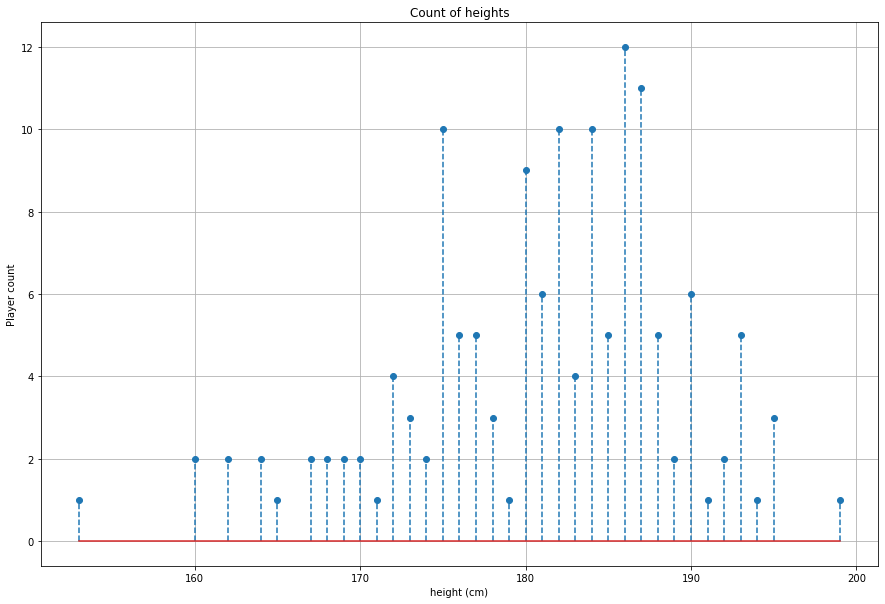

In [46]:
fig,ax = loliChartCount(wVb['height'].value_counts().sort_index(), 'Count of heights',
                       'height (cm)', 'Player count')

However, this is not a probability distribution sample. To do that, normalization is needed. To normalize, we divide each playercount $x_{i}$, by the total number of players n, so we end up with:  
$p(-\infty < X < \infty) = \sum \limits _{i=1} ^ {n} \frac {x_{i}}{n} = 1$  
given that  
$\sum \limits _{i=1} ^ {n} x_{i} = n$  
then:  
$p(X=x_{i}) = \frac{x_{i}}{n}$

In [47]:
def probDensity(series):
    n = series.size
    return series.value_counts().sort_index()/n

def myGaussian(x, mean, std):
    return np.exp(-0.5*((x-mean)/std)**2)/(std*np.sqrt(2*np.pi))

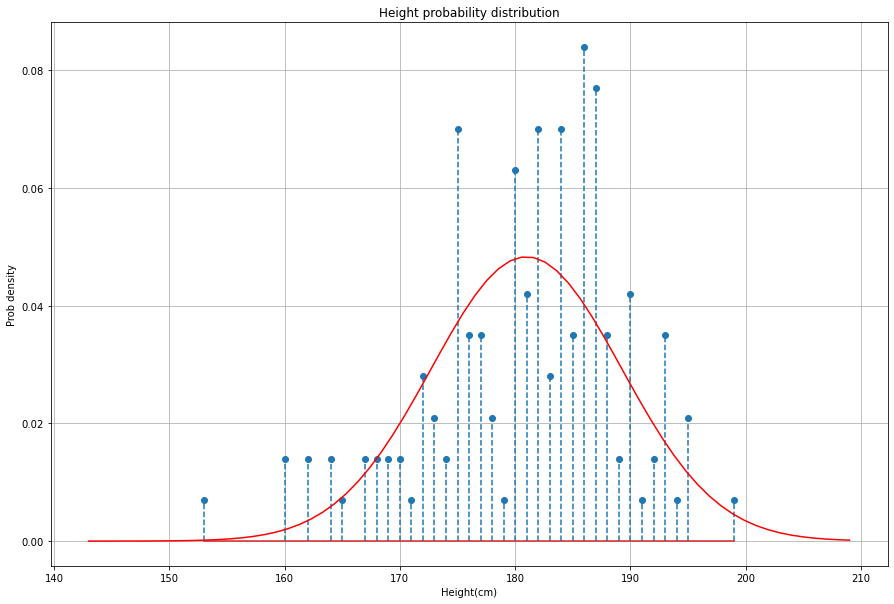

In [48]:
heightDist = probDensity(wVb['height'])

fig, ax = loliChartCount(heightDist, 'Height probability distribution', 'Height(cm)',
                         'Prob density')
x = np.linspace(wVb['height'].min() - 10, wVb['height'].max() + 10, 
                wVb['height'].max()+10-(wVb['height'].min() - 10))
plt.plot(x, myGaussian(x, wVb['height'].mean(), wVb['height'].std()), color = 'red')

Why is the normal distribution 'shorter' than our actual distribution? We are approximating a discrete distribution to a continuous one, which is taking into account the probability of a player's height to be a non-integer number. This comes to a problem of normalization, which can be done to better approximate to a continuous distribution, by generating middle points for example. Nevertheless, this is just for visualization.  
The more our distribution resembles a normal, the more accurate our test will be. In our case, we have a meh similarity. There are parameters to determine resemblance, but to keep it simple and for the sake of this exercise, let's assume the distribution follows a normal function.

### - Exercici 1

Agafa un conjunt de dades de tema esportiu que t'agradi i selecciona un atribut del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%.  

Even though the heights probability distribution is not normal, let's try the t-test for a single variable:    
$H_{0}:$ The average height of the women volleyball players is $\mu=$180 cm. *This is my hypothesis*  
$H_{a}:$ $\bar{X} \neq \mu$     
The average height of the women volleyball player is $\bar{X} = $
{{'{: .3f}'.format(wVb['height'].mean())}}cm. *This is my observation*  
$s =$ {{'{:.3f}'.format(wVb['height'].std())}}cm *For simplicity, let's assume $\sigma$ for $H_{0}$ equal to s*

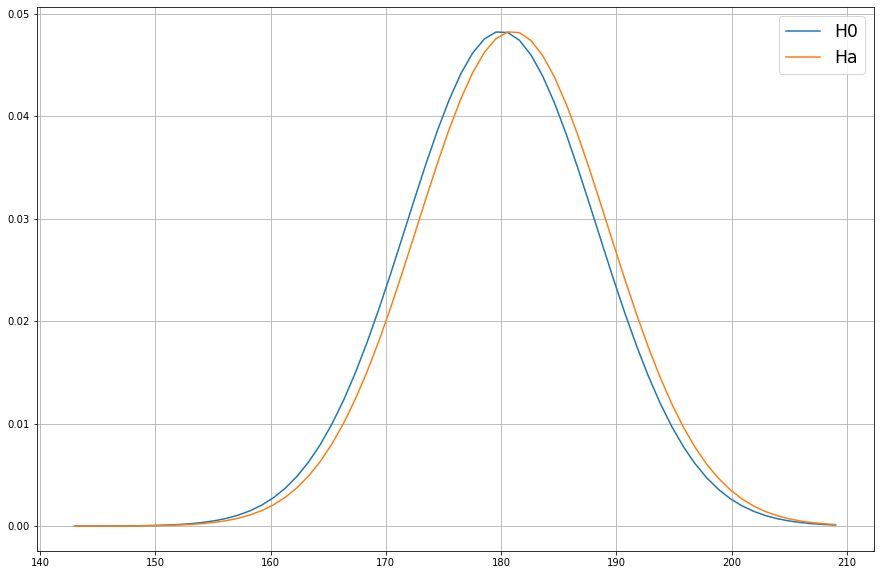

In [55]:
fig, ax = plt.subplots(figsize = (15,10))
x = np.linspace(wVb['height'].min() - 10, wVb['height'].max() + 10, 
                wVb['height'].max()+10-(wVb['height'].min() - 10))
ax.plot(x, myGaussian(x, 180, 8.263), label = 'H0')
ax.plot(x, myGaussian(x, 180.979, 8.263), label = 'Ha')
ax.grid(b=True)
ax.legend(fontsize = 'xx-large')

Just by looking at it, given the sample, I'd say our hypothesis is very likely to be correct. Let's see what the *t-test* has to say

In [56]:
from scipy.integrate import quad #fairly easy to use integration method

def mytTest(data, h0Mean):
    try:
        t = (data.mean()-h0Mean)/data.std()
    except ZeroDivisionError:
        print('If the standard deviation is 0, all elements are equal' +  
              ' and there is no probability distribution, only certainty')
    return t

def pValueR(t, h0mean, std):
    return quad(myGaussian, h0mean+t*std, np.inf, args = (h0mean, std))

def pValueL(t, h0mean, std):
    return quad(myGaussian, -np.inf, h0mean-t*std, args = (h0mean, std))    
    
def myGaussian(x, mean, std):
    return np.exp(-0.5*((x-mean)/std)**2)/(std*np.sqrt(2*np.pi))

def verdict(a, p):
    if p > a:
        print('The null hypothesis was correct!')
    else:
        print('The null hypothesis was incorrect!')

In [58]:
h0mean = 180
std = wVb['height'].std()
a = 0.05 #This is my alpha
t = mytTest(wVb['height'], h0mean)
print(t)
pr = pValueR(t, h0mean, std) #Both values should be the same since the distribution
pl = pValueL(t, h0mean, std) #is symmetrical. But just in case.
verdict(a,pr[0]+pl[0]) #the return of waud is a tuple containing the value and the estimated error

0.11848508197641848
The null hypothesis was correct!
